In [4]:
from glob import glob
from matplotlib import pyplot as plt
import cv2
import random
import numpy as np
from numpy.linalg import inv

In [5]:
def show_image(location, title, img, width=None):
    if width is not None:
        plt.figure(figsize=(width, width))
    plt.subplot(*location)
    plt.title(title, fontsize=8)
    plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    if width is not None:
        plt.show()
        plt.close()

29.970029


Read a new frame:  False 466


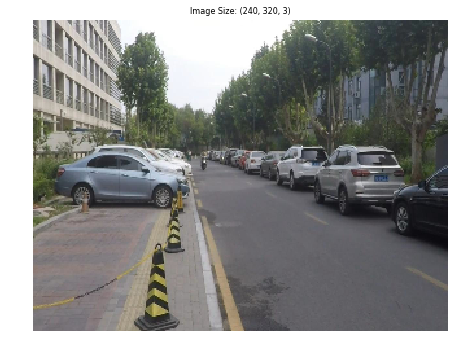

In [6]:
plt.figure(figsize=(20, 40))
video_path = "/Users/plusub/PycharmProjects/deep-online-video-stabilization/data/train/stable/1.avi"
frame_path = "/Users/plusub/PycharmProjects/deep-online-video-stabilization/data/train/stable/1/"
frame_count = 1
success = True
cap = cv2.VideoCapture(video_path)
print(cap.get(cv2.CAP_PROP_FPS))
while success:
    success, frame = cap.read()
    if not success:
        print('Read a new frame: ', success, frame_count)
    params = [cv2.IMWRITE_PXM_BINARY, 1]
    # cv2.imwrite(frame_path + "%d.jpg" % frame_count, frame, params)
    frame_count += 1
cap.release()
image = plt.imread(frame_path + "1.jpg")
image = cv2.resize(image, (320, 240))
show_image((6, 2, 1 + 1), "Image Size: " + str(image.shape), image)
plt.show()
plt.close()


## Let's now read in one image and start experimenting with it.

Like the paper describes we will take the image and do the following to prepare it:
1. Resize to 320x240
2. Convert to grayscale

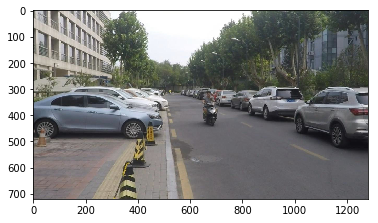

In [7]:
loc_list = glob(frame_path + "*.jpg")
test_image = plt.imread(loc_list[8])
w, h, _ = test_image.shape
B = test_image[:, :, 0]
G = test_image[:, :, 1]
R = test_image[:, :, 2]

test_image = cv2.resize(test_image, (320, 240))
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
# plt.imshow(test_image, cmap='gray')
# plt.show()

new_img = np.zeros((w, h, 3)).astype("uint8")
new_img[:, :, 0] = B
new_img[:, :, 1] = G
new_img[:, :, 2] = R
plt.imshow(new_img)
plt.show()

### Now we need to pick a position `P` that'll be the location of the patch.

Parameters we will use are the following:
* `rho = 32`
* `patch_size = 128x128`

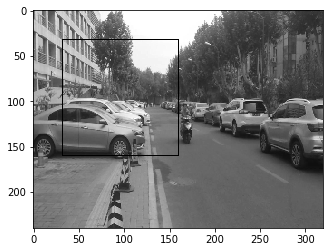

In [48]:
rho = 8
patch_size = 128

top_point = (32, 32)
left_point = (patch_size + 32, 32)
bottom_point = (patch_size + 32, patch_size + 32)
right_point = (32, patch_size + 32)

annotated_image = test_image.copy()

four_points = [top_point, left_point, bottom_point, right_point]

cv2.polylines(annotated_image, np.int32([four_points]), 1, (0, 0, 0))
plt.imshow(annotated_image, cmap='gray')
plt.show()


## Now we will create four random (delta_x, delta_y) tuples that are in the range [-rho, rho].

These 4 tuples are used to perturb four corners of the rectange patch. Then we show the perturbed patch.

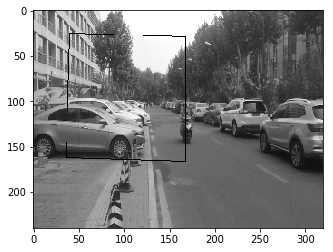

In [49]:
perturbed_four_points = []
for point in four_points:
    perturbed_four_points.append((point[0] + random.randint(-rho,rho), point[1]+random.randint(-rho,rho)))

perturbed_annotated_image = test_image.copy()
cv2.polylines(perturbed_annotated_image, np.int32([perturbed_four_points]), 1, (0,0,0))
plt.imshow(perturbed_annotated_image, cmap='gray')
plt.show()

## Now that we have both the original patch and the perturbed patch we generate the homography matrix using the opencv2  `getPerspectiveTransform` method.

In [50]:
# h is the homography matrix
H = cv2.getPerspectiveTransform( np.float32(four_points), np.float32(perturbed_four_points) )
print(H)

[[ 9.93851897e-01 -3.94823516e-02  9.16813965e+00]
 [ 3.12208377e-02  1.02442602e+00 -8.96322117e+00]
 [ 6.86172257e-06 -2.35013998e-04  1.00000000e+00]]


## Now we generate the inverse matrix of the homorgrapy matrix.

This wil be used to warp the original image. In the paper this is denoted as `I'`

In [51]:
H_inverse = inv(H)
print(H_inverse)

[[ 1.00509463e+00  3.66987817e-02 -8.88590865e+00]
 [-3.07552695e-02  9.77044791e-01  9.03943716e+00]
 [-1.41245994e-05  2.29367386e-04  1.00218537e+00]]


## Now we genenerate the Image using opencv2  `warpPerspective` method.


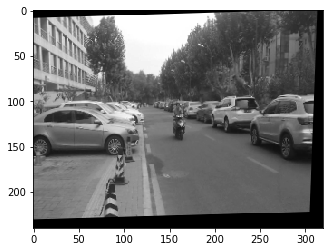

In [52]:
warped_image = cv2.warpPerspective(test_image,H_inverse, (320,240))
plt.imshow(warped_image, cmap='gray')
plt.show()

## Now that we have image `I'` we place a patch at the same position `P`.

This patch is denoted as `Ip` in the paper.

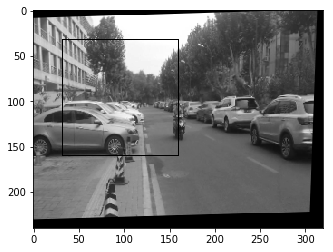

In [53]:
annotated_warp_image = warped_image.copy()
cv2.polylines(annotated_warp_image, np.int32([four_points]), 1, (0,0,0))
plt.imshow(annotated_warp_image, cmap='gray')
plt.show()

## Finally we generate the datum that we will feed into the model. This datum tuple will consist of the following:

1. I<sup>p</sup> = the patch from the original paper.
2. I<sup>'</sup><sub>p</sub> = the patch from warped Image
3. `perturbed_four_points` = the delta points that were used to generate the homography matrix

NOTE: the two patches are stacked to create a 2D image of size 128x128. Hence the final feature size will be (128,128, 2) and the label will be the perturbed four points.

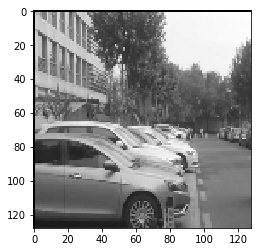

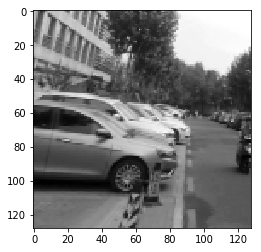

In [41]:
Ip1 = annotated_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]
Ip2 = warped_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]

plt.imshow(Ip1, cmap='gray')
plt.show()

plt.imshow(Ip2, cmap='gray')
plt.show()

In [43]:
training_image = np.dstack((Ip1, Ip2))
print(training_image.shape)

H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
print(H_four_points)

(128, 128, 2)
[[ -5  12]
 [ -2 -18]
 [ 20  29]
 [ 19  27]]


## Final Datum is below

In [92]:
datum = (training_image, H_four_points)
print(datum)

(array([[[  0, 151],
        [  0, 150],
        [  0, 150],
        ..., 
        [  0, 155],
        [  0, 156],
        [  0, 158]],

       [[  0, 148],
        [187, 148],
        [179, 148],
        ..., 
        [163, 157],
        [165, 158],
        [162, 157]],

       [[  0, 146],
        [178, 146],
        [176, 147],
        ..., 
        [164, 159],
        [175, 159],
        [175, 158]],

       ..., 
       [[  0, 182],
        [150, 182],
        [151, 181],
        ..., 
        [ 87, 127],
        [138, 173],
        [108, 191]],

       [[  0, 179],
        [151, 180],
        [150, 177],
        ..., 
        [ 59, 170],
        [137, 166],
        [135, 169]],

       [[  0, 175],
        [150, 172],
        [151, 173],
        ..., 
        [129, 168],
        [172, 116],
        [148, 139]]], dtype=uint8), array([[ 19, -28],
       [-21, -30],
       [ 28,  -3],
       [ 16, -20]]))
